# DS Methodology Guideline

##### Author information
- Name: YoungWoo Cho
- email address: veryssp129@handong.ac.kr
- GitHub: https://github.com/jayjo9/bigdata_design
- Youtube URL: https://youtu.be/y4YMZXb5g60

#### Part 1. Brief background of methodology
- __Explain the situation before this methodology was introduced.__  
    - Although the number of core data is small, such as detecting fraudulent transactions, identifying defective products, and analyzing abnormal patient data, they have the characteristic of being key variables that must be identified. The DBScan algorithm was used to detect outliers well in cluster analysis by taking advantage of the fact that it has characteristics that are different from other data. However, the curse of dimensionality, a chronic problem in cluster analysis, was an obstacle. As the number of variables used to determine outliers increases, the problem of increasing distances arises. In addition, as the number of data points increases, the amount of distance calculation required to find neighbors also increases, which slows down the learning speed.  
  
- __Explain why this methodology is introduced and where it can be used.__
    - The Isolation Forest algorithm emerged to overcome the curse of dimensionality and slow speed, which are problems associated with distance-based algorithms. Since it is based on the decision tree algorithm, it is characterized by using partitioning rather than distance when identifying outliers. This allows it to be easily applied in the process of detecting outliers in high-dimensional data. Additionally, it can be useful when the key data you want to find (such as the number of hacking incidents, the number of defective products, etc.) only constitutes a small portion of the total data.

#### Part 2. Key concept of methodology
- **Explain the key concept of the methodology with mathematical equations.**
    - Process
      - step 1: Data points to be used for tree creation are randomly extracted.
      - step 2: Partition the data by random features, until each data point is located at a unique node.
      - step 3: Calculate the number of divisions required for each data point to be isolated.
      - step 4: According to the random forest technique, the entire process is repeated and multiple trees are created.
      - step 5: Calculate the anomaly score
          - Anomaly score
            $$ s(x, n) = 2^{-\frac{E(h(x))}{c(n)}} $$  
            $$ c(n) = \text{(average number of divisions for all  observations)} $$
            $$ E(h(x)) = \text{(expectation number of divisions for each data x)} $$
      -  step 6: Interpret the results to determine outliers using threshold.
        $$
s(x, n) =
\begin{cases}
1 & \text{if }  E(h(x)) = 0 \\
0.5 & \text{if } E(h(x)) = c(n) \\
0 & \text{if }  E(h(x)) = n-1
\end{cases}
$$

- **Explain the main strength of the methodology.**
   - Fast Calculation speed, because everything is random (when choosing data to train, and features to divide)
   - You can set the ratio of outliers you want to detect, and if you do not know the ratio, the model applies the optimal ratio setting the threshold automatically.

#### Part 3-1. Simple Example
- **Using a very simple toy data, write down a sample code.**
- **You must present the result, what it means, and how it can be used.**
    - Iris data was used as an example of an isolation forest.
    - There are three Key hyperparameters n_estimators, max_samples, and contamination.
        - n_estimators: Number of trees to be generated by ensemble technique (step 5)
        - max_samples: Number of data points to be used when training each tree (step 1)
        - contamination: Set a threshold to distinguish outliers by the entered ratio (step 7 / default: auto)
    - Other hyperparameters(Used to prevent overfitting)
        - max_features: Proportion of features to be used for segmentation
        - bootstrap: Select between restoration and non-restoration extraction of learning data

In [1]:
from sklearn.datasets import load_iris
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Import Iris data and create data frame
iris = load_iris()
X = iris.data
df = pd.DataFrame(X, columns=iris.feature_names)

# Add 10 outlier values
np.random.seed(19)
outliers = np.random.uniform(low=2, high=9, size=(10, 4))
X_total = np.vstack([X, outliers])

# Create and train an Isolation Forest model
clf = IsolationForest(n_estimators=100, max_samples=256, contamination=0.0625, random_state=19)
clf.fit(X_total)

# Outlier prediction (1: normal, -1: outlier)
y_pred = clf.predict(X_total)
anomaly_scores = clf.score_samples(X_total)

# Add the column of result and anomaly points
df_total = pd.DataFrame(X_total, columns=iris.feature_names)
df_total['outlier'] = y_pred
df_total['anomaly_score'] = abs(anomaly_scores)

# Show the result
print(df_total["outlier"].value_counts(), "\n")


outlier
 1    150
-1     10
Name: count, dtype: int64 



C:\Users\jo\anaconda3\envs\py38\lib\site-packages\sklearn\ensemble\_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (160). max_samples will be set to n_samples for estimation.
  warn(


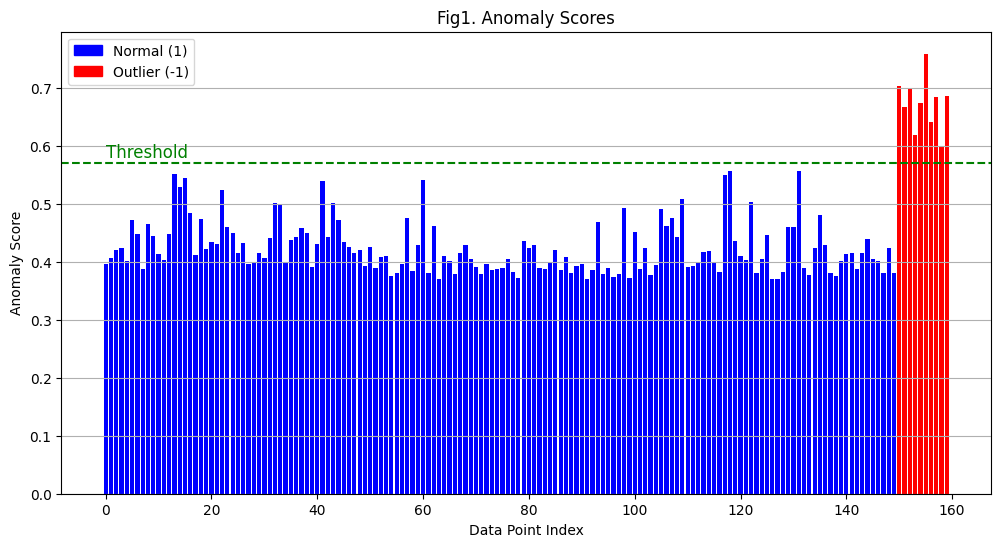

In [2]:
plt.figure(figsize=(12, 6))
# blue = normal / red = outlier
plt.bar(df_total.index, df_total['anomaly_score'], color=['blue' if x == 1 else 'red' for x in df_total['outlier']])
plt.title('Fig1. Anomaly Scores')
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
# Add Threshold line
plt.axhline(y=0.57, color='green', linestyle='--', label='Threshold (0.55)')
plt.text(x=0, y=0.58, s='Threshold', color='green', fontsize=12)
# Add legend
normal_patch = mpatches.Patch(color='blue', label='Normal (1)')
outlier_patch = mpatches.Patch(color='red', label='Outlier (-1)')
plt.legend(handles=[normal_patch, outlier_patch], loc='upper left')
plt.grid(axis='y')
plt.show()

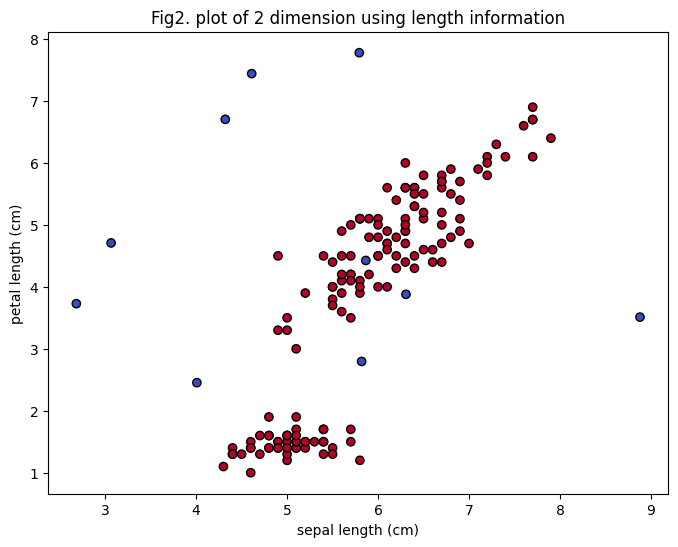

In [3]:
plt.figure(figsize=(8, 6))
# scatter plot using sepal length and petal length
plt.scatter(X_total[:, 0], X_total[:, 2], c=y_pred, cmap='coolwarm', edgecolor='k')
plt.title("Fig2. plot of 2 dimension using length information")
plt.xlabel(iris.feature_names[0])  # sepal length
plt.ylabel(iris.feature_names[2])  # petal length
plt.show()

- You can see that all 10 added outliers were detected.
- The anomaly points of all data points were visualized as bar graphs. It can be seen that normal values ​​and outliers are distinguished based on the threshold.
- The detection results were visualized in two dimensions using petal length and sepal length. You can see that 10 blue dots were detected as outliers.

#### Part 3-2. Real Example
- Let’s explore a real-world use case using credit card payment data.
- The goal is to find small amounts of fraudulent payments among large amounts of credit card payment data.
- Let's compare the training time and Evaluation indicators of the two algorithms.

In [4]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
, confusion_matrix
from sklearn.model_selection import train_test_split
import time 

# 1. Import credit card payment information data
from sklearn.datasets import fetch_openml
data = fetch_openml("creditcard", version=1, as_frame=True)

# 2. Create data frame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Class'] = data.target

# 3. devide target variable
X = df.drop(columns=['Class'])
y = df['Class'].astype(int)

# 4. Split into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\jo\anaconda3\envs\py38\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
# 5-Isolation. Isolation Forest model
i_forest = IsolationForest(n_estimators=200, contamination="auto", random_state=42)

# 6-Isolation. Measure model training time
start_time = time.time()  # Start time
i_forest.fit(X_train)     # Train the model
end_time = time.time()    # Check the end time

# 7-Isolation. Print the time result
training_time = end_time - start_time
print(f"Time taken to train the model: {training_time:.2f}seconds\n")

# 8-Isolation. Predict the test data
y_pred_test = i_forest.predict(X_test)
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]

# 9-Isolation. Evaluate the model
print("<Evaluation of Isolation Forest>")
print(confusion_matrix(y_test, y_pred_test), "\n")

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Time taken to train the model: 0.50seconds

<Evaluation of Isolation Forest>
[[82542  2765]
 [   23   113]] 

Accuracy: 0.9674
Precision: 0.0393
Recall: 0.8309


In [11]:
from sklearn.cluster import DBSCAN
# 5-DBSCAN. DBSCAN model
dbscan = DBSCAN(eps=2, min_samples=3)

# 6-DBSCAN. Measure model training time
start_time = time.time()  # Start time
dbscan.fit(X_train)       # Train the model
end_time = time.time()    # Check the end time

# 7-DBSCAN. Print the time result
training_time = end_time - start_time
print(f"Time taken to train the model: {training_time:.2f}seconds\n")

# 8-DBSCAN. Predict the test data
y_pred_test = dbscan.fit_predict(X_test)
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]

# 9-DBSCAN. Evaluate the model
print("<Evaluation of DBSCAN>")
print(confusion_matrix(y_test, y_pred_test), "\n")

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Time taken to train the model: 91.98seconds

<Evaluation of DBSCAN>
[[41052 44255]
 [    8   128]] 

Accuracy: 0.4820
Precision: 0.0029
Recall: 0.9412


- Isolation Forest
    - It took only 1.83 seconds to learn, and the accuracy was about 97%.
    - When the rate of outliers (fraudulent transactions) is unknown, setting contamination="auto" has the advantage of allowing the model to automatically set the threshold and detect outliers.
    - Given the low precision, there are many cases where normal data is mistaken for fraudulent data, but considering the high recall, it is rare for fraudulent data to be mistaken for normal data. In other words, if the goal is to detect fraud damage as much as possible, it can be interpreted as an appropriate ratio of precision and recall. If you want to focus more on precision, you can lower the number of FPs by modifying the contamination parameter.
 
- DBSCAN
    - Even though the model trained for about 92 seconds, it achieved only 48% accuracy.
    - When analyzed using the confusion matrix, it can be said that normal data and fraudulent data were each recorded with a 50% probability. This cannot be seen as correct learning.
    - The reason why learning did not occur properly is interpreted as the fact that sufficient distance (eps) was not provided as a hyperparameter to reduce the number of outliers. However, if you increase the distance further, you will need much more time than 34 seconds. This can be seen as a problem of the curse of dimensionality.